This notebook is dedicated to study the change in the behavior of the victims over time. We consider data of the past five years.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker

In [6]:
PV_data = pd.read_csv('./data/police_violence_full_date.csv', index_col=0)
PV_data['year'] = pd.DatetimeIndex(PV_data['date']).year
PV_data['month'] = pd.DatetimeIndex(PV_data['date']).month
PV_data = PV_data.query('year >= 2015')
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,criminal_charges,victim_armed,alleged_weapon,victim_fleeing,year,month
6177,41.0,Male,black,2015-04-15,Spartanburg,SC,No known charges,Allegedly Armed,knife,not fleeing,2015,4
2363,29.0,Male,black,2018-09-26,Newark,NJ,No known charges,Vehicle,vehicle,car,2018,9
2364,37.0,Male,black,2018-09-25,Newark,NJ,No known charges,Allegedly Armed,gun,NaN,2018,9
5686,28.0,Male,black,2015-09-23,Wilmington,DE,No known charges,Allegedly Armed,gun,not fleeing,2015,9
2366,34.0,Male,black,2018-09-25,Orlando,FL,No known charges,Allegedly Armed,gun,not fleeing,2018,9


In [13]:
races = PV_data.victim_race.unique()
colors= ["black", "red", "blue"] #the color palette for the plots

In [7]:
def f(row):
    x= datetime(year=row['year'], month=row['month'], day=1)
    return x
                                      
PV_data['period'] = PV_data.apply(lambda row: f(row), axis=1)

PV_data['ordinal_period'] = PV_data.apply(lambda x: x['period'].toordinal(), axis=1)
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,criminal_charges,victim_armed,alleged_weapon,victim_fleeing,year,month,period,ordinal_period
6177,41.0,Male,black,2015-04-15,Spartanburg,SC,No known charges,Allegedly Armed,knife,not fleeing,2015,4,2015-04-01,735689
2363,29.0,Male,black,2018-09-26,Newark,NJ,No known charges,Vehicle,vehicle,car,2018,9,2018-09-01,736938
2364,37.0,Male,black,2018-09-25,Newark,NJ,No known charges,Allegedly Armed,gun,NaN,2018,9,2018-09-01,736938
5686,28.0,Male,black,2015-09-23,Wilmington,DE,No known charges,Allegedly Armed,gun,not fleeing,2015,9,2015-09-01,735842
2366,34.0,Male,black,2018-09-25,Orlando,FL,No known charges,Allegedly Armed,gun,not fleeing,2018,9,2018-09-01,736938


In [18]:
"""total_df: Dataframe representing the total_count of victims per race, each month(period)"""

total_df = PV_data.groupby(['victim_race', 'ordinal_period'], as_index=False).count()
total_df['total_count'] = total_df.State #We use `State` in the splitting because it doesn't contain any NaN values, so the count is correct
total_df = total_df[['victim_race', 'ordinal_period', 'total_count']]
total_df.head()

,victim_race,ordinal_period,total_count
0,black,735599,22
1,black,735630,23
2,black,735658,36
3,black,735689,29
4,black,735719,23


In [19]:
"""guns_df: Dataframe representing the number of victims carrying a gun in each race, every period"""

guns_df = PV_data.query('alleged_weapon == "gun"')
guns_df = guns_df.groupby(['victim_race', 'ordinal_period'], as_index=False).count()
guns_df['guns_count'] = guns_df.State
guns_df = guns_df[['victim_race', 'ordinal_period', 'guns_count']]
guns_df = pd.merge(guns_df, total_df, on=['victim_race', 'ordinal_period'])
guns_df = pd.merge(PV_data[['ordinal_period', 'period']], guns_df, on='ordinal_period')
guns_df['percentage'] = np.around(guns_df.guns_count / guns_df.total_count*100)

guns_df.head()

,ordinal_period,period,victim_race,guns_count,total_count,percentage
0,735689,2015-04-01,black,14,29,48.0
1,735689,2015-04-01,hispanic,7,15,47.0
2,735689,2015-04-01,white,25,43,58.0
3,735689,2015-04-01,black,14,29,48.0
4,735689,2015-04-01,hispanic,7,15,47.0


In [20]:
"""unarmed_df: Dataframe representing the number of victims unarmed, or unclear to be armed, in each race, every period"""

unarmed_df = PV_data.query('victim_armed in ["Unarmed", "Unclear"]')
unarmed_df = unarmed_df.groupby(['victim_race', 'ordinal_period'], as_index=False).count()
unarmed_df['unarmed_count'] = unarmed_df.State
unarmed_df = unarmed_df[['victim_race', 'ordinal_period', 'unarmed_count']]

unarmed_df = pd.merge(unarmed_df, total_df, on=['victim_race', 'ordinal_period'])
unarmed_df = pd.merge(PV_data[['ordinal_period', 'period']], unarmed_df, on='ordinal_period')
unarmed_df['percentage'] = np.around(unarmed_df.unarmed_count / unarmed_df.total_count*100)

unarmed_df.head()

,ordinal_period,period,victim_race,unarmed_count,total_count,percentage
0,735689,2015-04-01,black,9,29,31.0
1,735689,2015-04-01,hispanic,4,15,27.0
2,735689,2015-04-01,white,6,43,14.0
3,735689,2015-04-01,black,9,29,31.0
4,735689,2015-04-01,hispanic,4,15,27.0


In [21]:
"""flee_df: Dataframe representing the number of victims who were not fleeing when killed, in each race and period"""

flee_df = PV_data.query('victim_fleeing == "not fleeing"')
flee_df = flee_df.groupby(['victim_race', 'ordinal_period'], as_index=False).count()
flee_df['not_fleeing_count'] = flee_df.State
flee_df = flee_df[['victim_race', 'ordinal_period', 'not_fleeing_count']]

flee_df = pd.merge(flee_df, total_df, on=['victim_race', 'ordinal_period'])
flee_df = pd.merge(PV_data[['ordinal_period', 'period']], flee_df, on='ordinal_period')
flee_df['percentage'] = np.around(flee_df.not_fleeing_count / flee_df.total_count*100)

flee_df.head()

,ordinal_period,period,victim_race,not_fleeing_count,total_count,percentage
0,735689,2015-04-01,black,11,29,38.0
1,735689,2015-04-01,hispanic,13,15,87.0
2,735689,2015-04-01,white,28,43,65.0
3,735689,2015-04-01,black,11,29,38.0
4,735689,2015-04-01,hispanic,13,15,87.0


In [22]:
data = [guns_df, unarmed_df, flee_df]

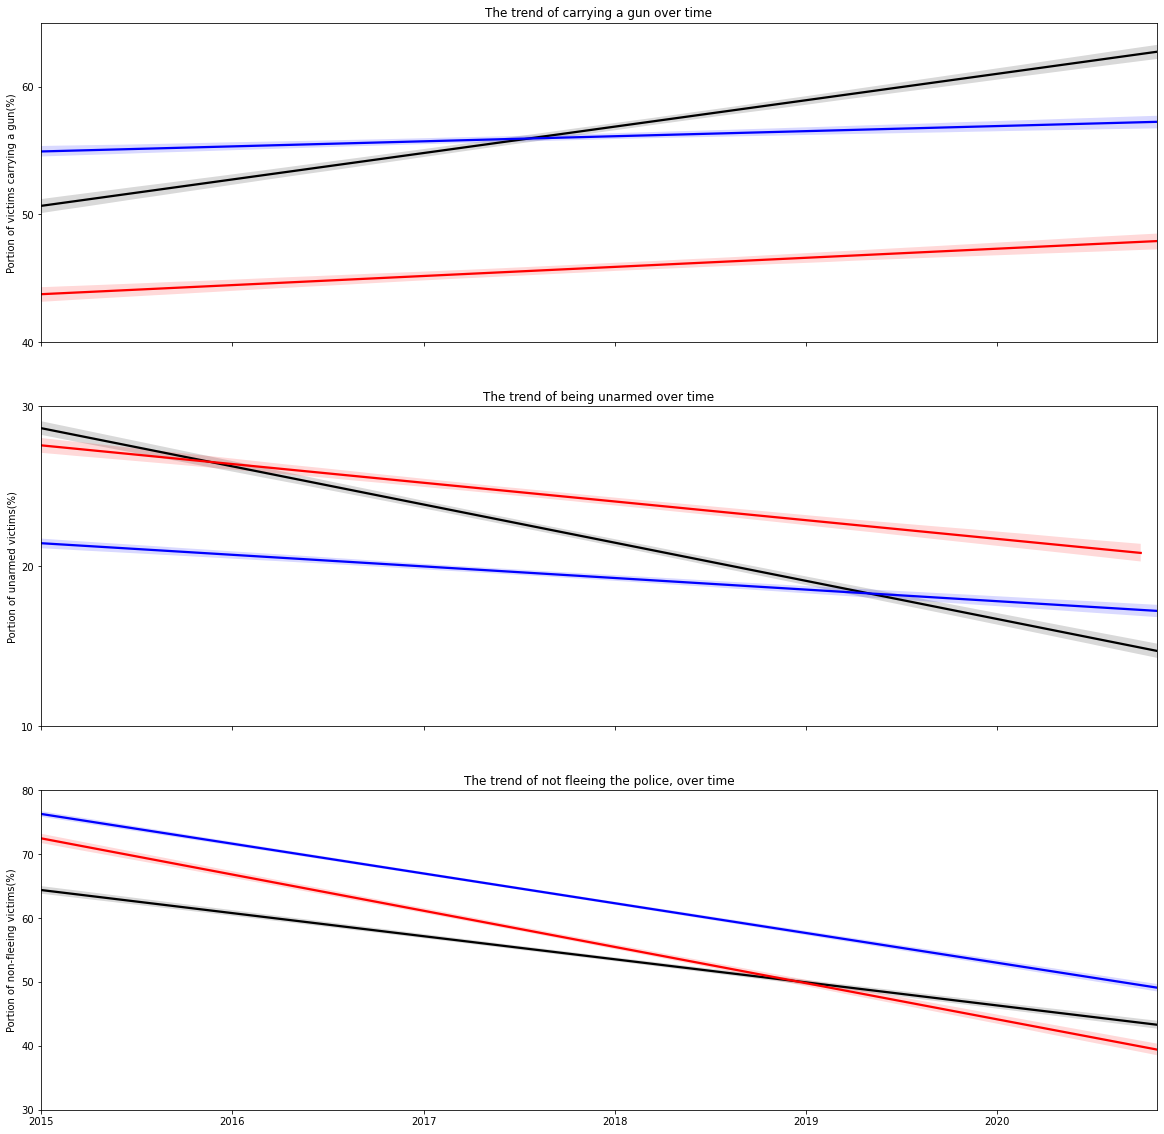

In [46]:
fig, axs = plt.subplots(3,1, sharex='col')
fig.set_size_inches(20, 20)


for i, df in zip(range(3), data):
    ax=axs[i]
    for race, color in zip(races, colors):
        sns.regplot(
            data=df.query('victim_race == @race'), 
            x='ordinal_period', 
            y='percentage', 
            ax=ax, 
            color=color, 
            scatter=False)
    
    ax.set_xlabel('')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    
    if i==0:
        ax.set_title("The trend of carrying a gun over time")
        ax.set_ylabel("Portion of victims carrying a gun(%)")
        ax.set_ylim(40,65)    

    elif i==1:
        ax.set_title("The trend of being unarmed over time")
        ax.set_ylabel("Portion of unarmed victims(%)")
        ax.set_ylim(10,30)    

    else:
        ax.set_title("The trend of not fleeing the police, over time")
        ax.set_ylabel("Portion of non-fleeing victims(%)")
        ax.set_ylim(30,80)    


ax.set_xlim(min(df['period']),)

fig = plt.gcf()
plt.show()
fig.savefig('./plots/subplots.png')


***